In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import ifft2
from scipy.ndimage import gaussian_filter
from scipy.fft import fftshift

import skimage
from scipy.interpolate import interp2d
from scipy.ndimage import gaussian_filter

# Phase Difference Matrix

Balci, Murat, et Hassan Foroosh. « Subpixel Registration Directly from the Phase Difference ». EURASIP Journal on Advances in Signal Processing 2006, nᵒ 1 (décembre 2006). https://doi.org/10.1155/ASP/2006/60796.


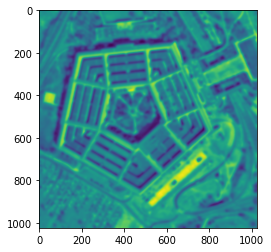

In [3]:
# ================
#  Generate data
# ================

# Pentagon aerial photo
# http://sipi.usc.edu/database/database.php?volume=aerials&image=37#top
image = skimage.data.camera()
image = skimage.io.imread('pentagon_1024.tiff')
image = skimage.exposure.rescale_intensity(image)
image = gaussian_filter(image, sigma=5)
plt.imshow(image);

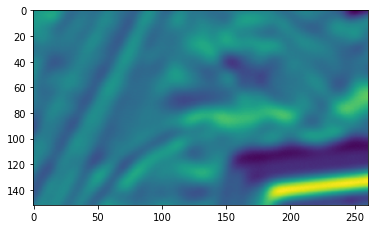

In [4]:
# Interpolation
x_span, y_span = np.arange(image.shape[0]), np.arange(image.shape[1])
x_grid, y_grid = np.meshgrid(x_span, y_span)

f = interp2d(x_span, y_span, image, kind='cubic')

x_A = np.arange(20, 281)
y_A = np.arange(80, 232) 

dx, dy = (0.7512, 10.101512)
A = f(x_A, y_A)
B = f(x_A + dx, y_A + dy)  #+ 0.81*np.random.randn(*np.shape(A))

plt.imshow(A - B);

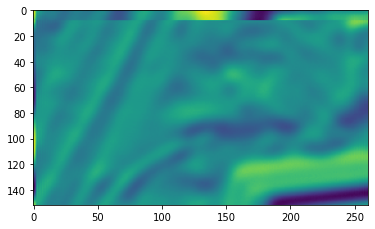

In [5]:
# FFT shift interpolation
a = np.fft.fft2(A)

kx = np.fft.fftfreq(A.shape[0])
ky = np.fft.fftfreq(A.shape[1])

k_xy = np.meshgrid(kx, ky, indexing='ij')

dx, dy = 50.2, 14.123
b2 = a*np.exp(-1j*(dx*k_xy[0] + dy*k_xy[1]))

B = np.abs( np.fft.ifft2(b2) ) + 0.1*np.random.randn(*A.shape)

plt.imshow(A - B);

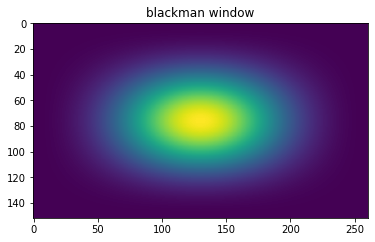

In [6]:
from scipy.signal.windows import blackman

u = blackman(A.shape[0])[:, np.newaxis]
v = blackman(A.shape[1])[np.newaxis, :]
window = np.matmul(u, v)

plt.imshow(window); plt.title('blackman window');

In [7]:
# ====================
#  Fourier Transform
# ====================
a = np.fft.fft2(A*window)
b = np.fft.fft2(B*window)

#a = np.fft.fft2(A)
#b = np.fft.fft2(B)

ab = a * b.conj()
ab = np.fft.fftshift( ab )

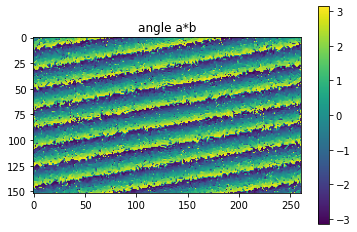

In [8]:
plt.imshow(np.angle(ab));
plt.title('angle a*b'); plt.colorbar();

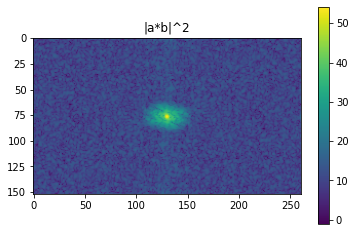

In [9]:
plt.imshow(np.log(np.abs(ab)**2));
plt.title('|a*b|^2'); plt.colorbar();

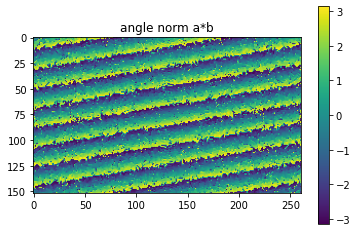

In [10]:
ab_normed = (ab)/np.abs(ab)
plt.imshow(np.angle(ab_normed));
plt.title('angle norm a*b'); plt.colorbar();

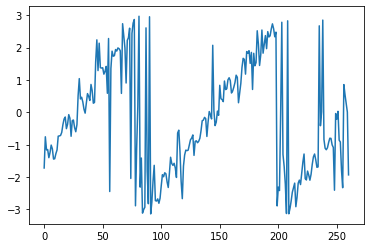

In [11]:
plt.plot(np.angle(ab)[150, :])

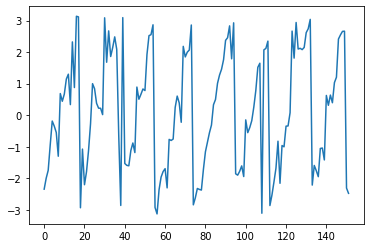

In [12]:
plt.plot(np.angle(ab)[:, 200])

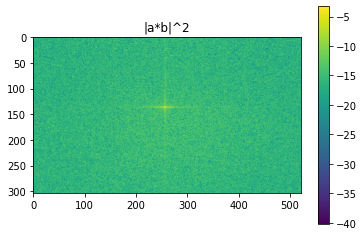

In [13]:
AB = np.fft.ifft2(ab/np.abs(ab), s=np.array(ab.shape)*2)
AB = np.fft.ifftshift(AB)
plt.imshow(np.log(np.abs(AB)**2));
plt.title('|a*b|^2'); plt.colorbar();

In [14]:
np.unravel_index(np.argmax(np.abs(AB), axis=None), AB.shape)

(136, 257)

In [15]:
A.shape

(152, 261)

In [16]:
# test unwraping

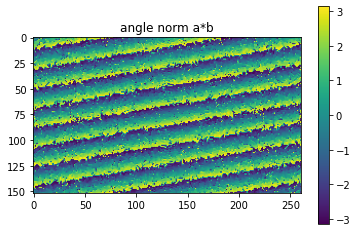

In [17]:
phase = np.angle( ab/np.abs(ab) )
plt.imshow(phase);
plt.title('angle norm a*b'); plt.colorbar();

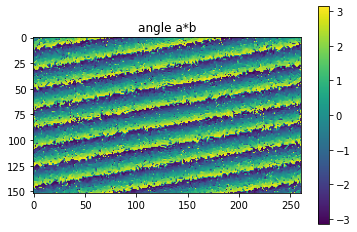

In [19]:
from scipy.linalg import lstsq#(a, b, cond=None, overwrite_a=False, 

In [20]:
from scipy.ndimage import median_filter#(input, size=None, 

In [21]:
def build_LSTSQ_matrix(x, y):
    x = x.flatten()
    y = y.flatten()
    ones = np.ones_like(x)
    M = np.stack([ones, x, y]).T
    return M

In [22]:
y, x = np.arange(phase.shape[0]), np.arange(phase.shape[1])
i_grid, j_grid = np.meshgrid(y, x, indexing='ij')

In [23]:
# crop
half_size = 5
i, j = 105, 200
i_slicing = np.s_[i - half_size:i + half_size + 1]
j_slicing = np.s_[j - half_size:j + half_size + 1]

[-42.21789803   0.30054381   0.05652008]


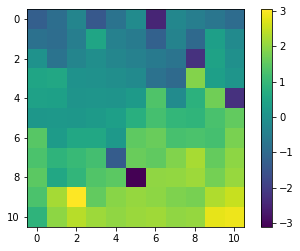

In [24]:
# seed
i_crop = i_grid[i_slicing, j_slicing].flatten()
j_crop = j_grid[i_slicing, j_slicing].flatten()
phase_crop = phase[i_slicing, j_slicing]

plt.imshow(phase_crop); plt.colorbar();

M_crop = build_LSTSQ_matrix(i_crop, j_crop)

coeff, residual, rank, s = lstsq(M_crop, phase_crop.flatten())
print(coeff)

In [25]:
M = build_LSTSQ_matrix(i_grid, j_grid)
plane = np.matmul(M, coeff)
plane = plane.reshape(phase.shape)

In [26]:
k = np.around( plane/(2*np.pi) )

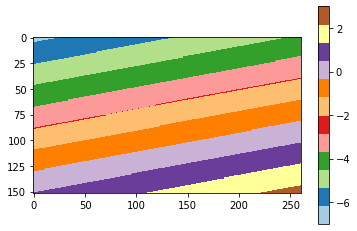

In [27]:
#k = median_filter(k, size=3).astype('int')
plt.imshow(k, cmap='Paired'); plt.colorbar();


[-42.16072647   0.2999732    0.05643983]


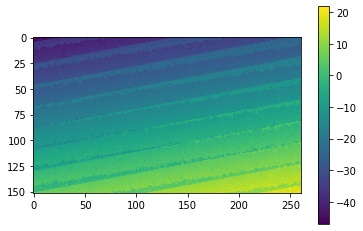

In [28]:
unwrap = phase + k*2*np.pi
plt.figure();
plt.imshow(unwrap); plt.colorbar();

coeff, residual, rank, s = lstsq(M, unwrap.flatten())
print(coeff)
plane = np.matmul(M, coeff)
plane = plane.reshape(phase.shape)
residuals = phase - plane % (2*np.pi)

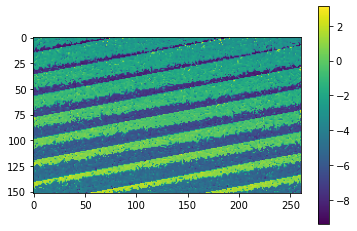

In [29]:
plt.imshow(residuals); plt.colorbar();

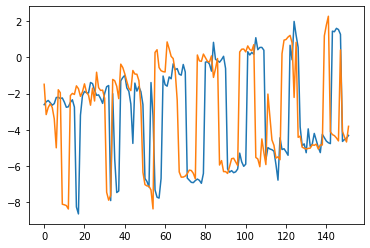

In [30]:
plt.plot(residuals[:, 100])
plt.plot(residuals[:, 10])

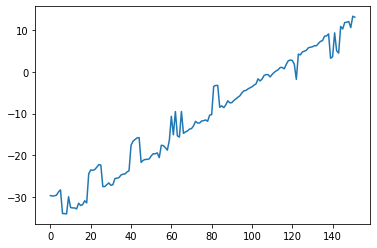

In [31]:
plt.plot(unwrap[:, 150])

## test 1D

In [32]:
from scipy.optimize import curve_fit#(f, xdata, ydata, p0=None, sigma=None, 
from scipy.optimize import least_squares

In [33]:
x = np.linspace(-10, 10, 234)
phi_true = (1.8 * x) + 0.4
phi = phi_true%(2*np.pi) - np.pi 

def unwrap(coeff):
    plane = coeff[0]*x + coeff[1]
    k = np.around( plane/(2*np.pi) )
    unwraped = phi + k*np.pi*2
    return unwraped

def loop(coeff, weight=None):
    
    unwraped = unwrap(coeff)

    a, b = np.polyfit(x, unwraped, deg=1, w=weight)
    r = phi - (a*x + b)
    return a, b, r

In [34]:
w = None
a, b = 2.0, 0.5

2.0329886008341496 0.5074048770458051


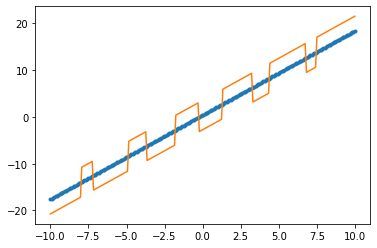

In [35]:
a, b, r = loop([a, b], weight=w)
print(a, b)
plt.plot(x, phi_true, '.')
plt.plot(x, unwrap([a, b]))

#r[r<0] = r[r<0]*2
w = ( 1 + r**2 )

In [36]:
plane = a*x + b
plane = plane%(2*np.pi) - np.pi
r = phi - plane

In [37]:
def fun(ab):
    a, b = ab
    plane = a*x + b
    plane = plane%(2*np.pi) - np.pi
    r = phi - plane
    #r[r<0] = r[r<0]*0.
    return np.sum( r**2 )

In [38]:
least_squares(fun, [1.42, 0])

 active_mask: array([0., 0.])
        cost: 969891.930226398
         fun: array([1392.76123598])
        grad: array([-76177.12136172, -59434.66612194])
         jac: array([[-54.69503271, -42.67398071]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 40
        njev: 22
  optimality: 76177.12136171613
      status: 2
     success: True
           x: array([4.40378853, 0.14770897])

In [39]:
plane = 1.809*x + 0.5
k = np.around( plane/(2*np.pi) )

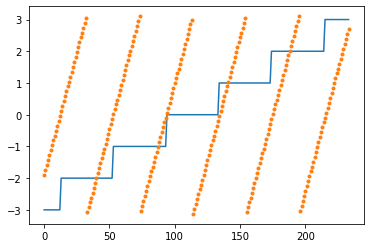

In [40]:
plt.plot(k)
plt.plot(phi, '.')

1.8584442495839668 0.5611073155687074


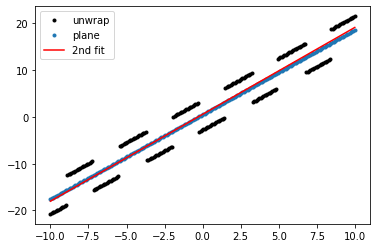

In [41]:
plt.figure()
plt.plot(x, phi + k*np.pi*2, '.k', label='unwrap')
plt.plot(x, plane, '.', label='plane')
a, b = np.polyfit(x, phi + k*np.pi*2, deg=1)
print(a, b)
plt.plot(x, a*x + b, 'r', label='2nd fit')
plt.legend();

In [42]:
# test 2

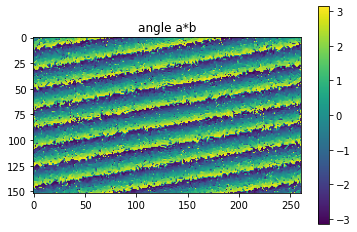

In [43]:
phi = np.angle(ab)
plt.imshow(phi);
plt.title('angle a*b'); plt.colorbar();

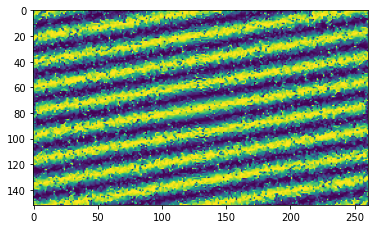

In [44]:
plt.imshow(np.cos(phi));

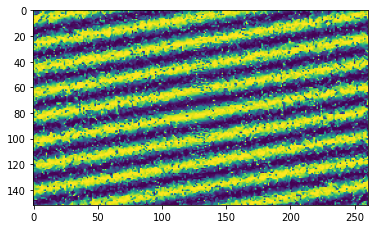

In [49]:
plt.imshow(np.arctan( np.sin(phi), np.cos(phi) ));

- fit (cos(phi), sin(phi)) instead of 
the peak summit quadratic, or phi%pi

- but non linear... so do the interpolation&fit directly--> high order transformation

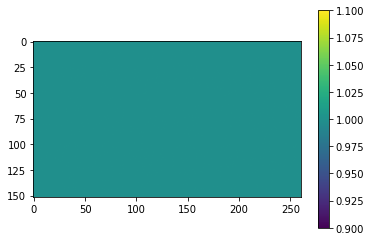

In [52]:
plt.imshow(np.sin(phi)**2 + np.cos(phi)**2 );
plt.colorbar()